In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import ast
from IPython.display import display

override_files = (list(Path('.').glob('**/overrides.yaml')))
df = pd.DataFrame()
for override_file in override_files:    
       
    factors = yaml.safe_load(override_file.read_text())
    factors = dict([elm.split('=') for elm in factors if elm[0] != '+'])
    
    factors = pd.DataFrame(factors,index=range(0,int(factors['epochs']))) #Factors df with a duplicate row per epoch
    factors['epoch'] = list(range(1,int(factors.epochs[0]) + 1 )) #Adding epoch number to each row
    
    log_file =  override_file.parent.parent /'TrainModel.log'
    with open(log_file) as f:
        metrics = [log.split("- ")[-1].strip().split(': ') for log in f.readlines()]
        metrics = pd.DataFrame({k:ast.literal_eval(v) for k,v in metrics}) #Metric df containing the log metrics
    
    #concat factor and metrics dfs to the final df
    df = pd.concat([df, pd.concat([factors, metrics],axis=1)])
    

In [34]:
#Shows the models that had a median validation accuracy greater that 65% over the last 4 epochs
val = df[df.epoch > 6].groupby(list(factors.columns[3:-1])).describe()['Validation Accuracy']
val = val.sort_values('50%',ascending=False).iloc[0:6,:]

display(val)

#The smallest of the below models performed the best according to the median validation accuracy. Likely due to less overfitting
#Should conduct further analysis on these models to determine the next experiement.

val = val.reset_index().iloc[:,0:-8]
val['modelID'] = range(1,val.shape[0]+1)

top_perf = pd.merge(left=df, right = val.reset_index(), how= 'left').pipe(lambda df_: df_[df_['modelID'].notnull()])

train_acc = top_perf.groupby(['modelID', 'epoch']).describe().loc[:,'Train Accuracy'].reset_index()
val_acc = top_perf.groupby(['modelID', 'epoch']).describe().loc[:,'Validation Accuracy'].reset_index()

count  \
modelconf.layersconf.Conv2D_1.filters modelconf.layersconf.Conv2D_2.filters modelconf.layersconf.Conv2D_3.filters modelconf.layersconf.Conv2D_1.kernel_size modelconf.layersconf.Conv2D_2.kernel_size modelconf.layersconf.Conv2D_3.kernel_size          
16                                    8                                     8                                     5                                         5                                         5                                           20.0   
                                      16                                    16                                    5                                         5                                         5                                           20.0   
32                                    16                                    16                                    5                                         5                                         5                                           20.0   
                                      8                                     16                                    5                                         3                                         5                                           20.0   
                                      16                                    16                                    3                                         5                                         5                                           20.0   
16                                    32                                    32                                    3                                         5                                         5                                           20.0   

                                                                                                                                                                                                                                                     mean  \
modelconf.layersconf.Conv2D_1.filters modelconf.layersconf.Conv2D_2.filters modelconf.layersconf.Conv2D_3.filters modelconf.layersconf.Conv2D_1.kernel_size modelconf.layersconf.Conv2D_2.kernel_size modelconf.layersconf.Conv2D_3.kernel_size             
16                                    8                                     8                                     5                                         5                                         5                                          0.658140   
                                      16                                    16                                    5                                         5                                         5                                          0.674258   
32                                    16                                    16                                    5                                         5                                         5                                          0.655409   
                                      8                                     16                                    5                                         3                                         5                                          0.660257   
                                      16                                    16                                    3                                         5                                         5                                          0.641353   
16                                    32                                    32                                    3                                         5                                         5                                          0.641950   

                                                                                                                                                                                                                       

Text(0.5, 0.98, 'Median Model Accuracy of Top 6 Performing Models')

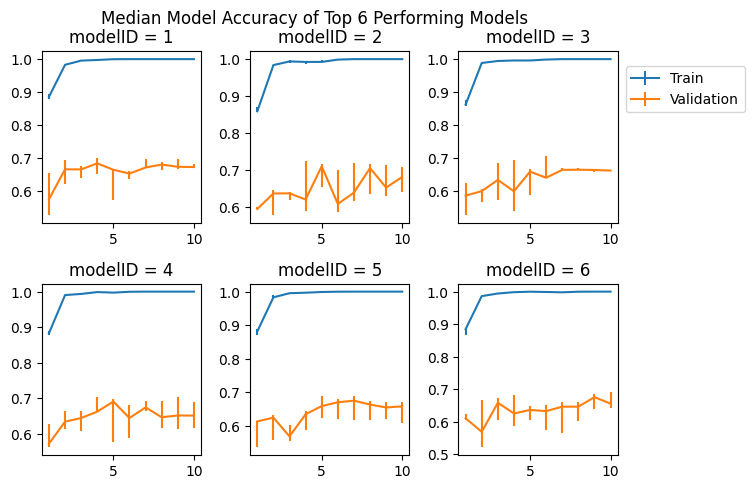

In [35]:
plt.figure()
for id in val_acc.modelID.unique():
    val_df = val_acc[val_acc.modelID == id]
    train_df = train_acc[train_acc.modelID == id]

    plt.subplot((230 + int(id)))

    plt.errorbar(x = train_df['epoch'],
                y = train_df['50%'],
                yerr = [(train_df['50%'] - train_df['25%']).to_numpy(), (train_df['75%'] - train_df['50%']).to_numpy()],
                label = 'Train')

    plt.errorbar(x = val_df['epoch'],
                y = val_df['50%'],
                yerr = [(val_df['50%'] - val_df['25%']).to_numpy(), (val_df['75%'] - val_df['50%']).to_numpy()],
                label = 'Validation')

    plt.title(f'modelID = {int(id)}')
    #plt.legend(loc=(0,0))

plt.tight_layout()
plt.legend(loc=(1.05,2))
plt.suptitle("Median Model Accuracy of Top 6 Performing Models", va = 'baseline')